<a href="https://colab.research.google.com/github/artysav97/MADE_2_Speech_pro/blob/main/HW5/asr_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 53.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:07, 89.3MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [4]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
############################################ добавленый\исправленый кусочек ############################################
        min_phonems_num = min(len(file_feats), len(file_ali)) 
        for frame in range(min_phonems_num):
            long_mfcc = np.array([])
            for i in range(-side_context, side_context + 1):
                append_num = max(min(frame + i, min_phonems_num - 1), 0)
                long_mfcc = np.append(long_mfcc, file_feats[append_num])
            data_list.append(np.append(long_mfcc, phones_dict[file_ali[frame]]))
############################################ конец добавления\исправления ############################################
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 2
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [5]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [6]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 1.9621



loss is: 1.7318



loss is: 1.6533



loss is: 1.6032



loss is: 1.5667



loss is: 1.5374



loss is: 1.5129



loss is: 1.4916



loss is: 1.4730



loss is: 1.4563
Time is: 1 min 46 sec


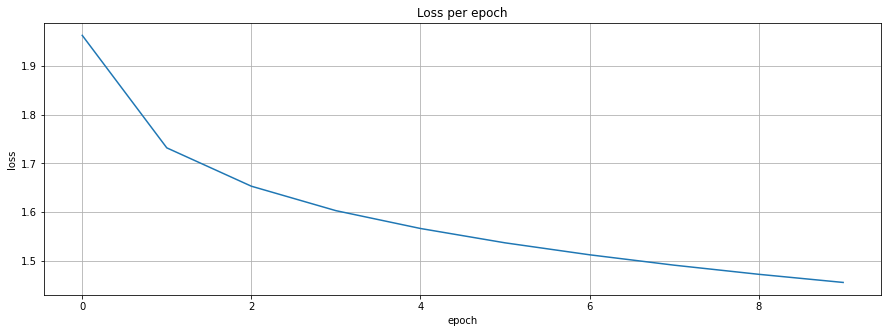

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [9]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.556


In [10]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.96 : 21806/22615
SPN: 0.00 : 1/534
AA0: 0.00 : 0/42
AA1: 0.39 : 672/1737
AA2: 0.00 : 0/76
AE0: 0.00 : 0/52
AE1: 0.57 : 2015/3561
AE2: 0.01 : 1/141
AH0: 0.37 : 2053/5534
AH1: 0.28 : 549/1978
AH2: 0.00 : 0/55
AO0: 0.00 : 0/29
AO1: 0.49 : 908/1865
AO2: 0.02 : 1/51
AW0: 0.00 : 0/7
AW1: 0.37 : 390/1062
AW2: 0.07 : 2/27
AY0: 0.00 : 0/42
AY1: 0.61 : 1825/2985
AY2: 0.00 : 0/200
B  : 0.37 : 574/1570
CH : 0.26 : 220/849
D  : 0.27 : 1057/3946
DH : 0.40 : 788/1982
EH0: 0.00 : 0/62
EH1: 0.29 : 814/2796
EH2: 0.00 : 0/97
ER0: 0.37 : 942/2564
ER1: 0.28 : 272/961
ER2: 0.00 : 0/6
EY0: 0.00 : 0/16
EY1: 0.55 : 1340/2446
EY2: 0.03 : 3/107
F  : 0.59 : 1376/2352
G  : 0.22 : 183/851
HH : 0.43 : 921/2127
IH0: 0.12 : 328/2773
IH1: 0.24 : 528/2197
IH2: 0.00 : 0/82
IY0: 0.36 : 797/2201
IY1: 0.58 : 1401/2416
IY2: 0.00 : 0/69
JH : 0.20 : 128/637
K  : 0.56 : 1749/3134
L  : 0.67 : 2800/4200
M  : 0.57 : 1796/3144
N  : 0.68 : 4014/5946
NG : 0.35 : 449/1298
OW0: 0.00 : 1/208
OW1: 0.37 : 733/1959
OW2: 0.00 : 0/54

### Распознавание по словарю с помощью нейронки

In [11]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [12]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [13]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, side_context, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    for frame in range(len(features)):
########################################### Изменение параметра features #######################################################
        # ftr_frame = features[frame]
        ftr_frame = np.array([])
        for i in range(-side_context, side_context + 1):
            append_num = max(min(frame + i, len(features) - 1), 0)
            ftr_frame = np.append(ftr_frame, features[append_num])
####################################################### Конец ###################################################################

        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [14]:
def run_recognizer(records_data_dict, side_context, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename], 
                                        side_context,
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [15]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, side_context, graph, net.cpu(), beam_threshold=100)


result: no_41474817_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.63 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [16]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, side_context, graph, net.cpu(), beam_threshold=50)


result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: one_ffa76c4a_nohash_0       ==> ONE
result: five_f852895b_nohash_0      ==> FIVE
result: eight_da584bc0_nohash_4     ==> EIGHT
result: two_fce65496_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ZERO
result: two_fb2f3242_nohash_0       ==> TWO
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: six_ffbb695d_nohash_0       ==> SIX
result: three_fce96bac_nohash_0     ==> THREE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: seven_fd32732a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> ONE
result: nine_fbe51750_nohash_0      ==> NINE
------------------------------------------------------------
WER is: 0.00%
Total time is: 13.35 sec

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

**Ответ**
> Контекст размера 1:
- loss уменьшился до 1.6583
- accuracy нейронной сети увеличилось до 0.506
- WER для YES/NO уменьшился до 0%
- WER для Digits уменьшился до 0%

> Контекст размера 2:
- loss уменьшился до 1.4543
- accuracy нейронной сети увеличилось до 0.552
- WER для YES/NO уменьшился до 0%
- WER для Digits уменьшился до 0%

Брать больший контекст для решения задачи не вижу необходимым

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

> **Ответ**

> При увеличении количества нейронов на каждом слое до 512 получены следующие результаты:
* Loss уменьшился до 1.2431
* Метрика accuracy выросла до 0.581

> При добавлении еще одного скрытого слоя получены следующие результаты:
* Loss уменьшился до 1.2088
* Метрика accuracy выросла до 0.585

> При увеличении количества нейронов на первых трех скрытых слоях до 1024 получены следующие результаты:
* Loss уменьшился до 0.9889
* Метрика accuracy выросла до 0.605

При всех этих преобразованиях качество распознавания снижается и WER увеличивается с 0% до 5-20%
Время же обучения нейросети увеличивается незначительно.
